# Non-contact in-motion tie/ballast detection

This study develops an effective system for in-motion and autonomous identification of crossties and ballast, toward implementing non-contact sensors that can evaluate the condition of railroad structures.  An array of sensors that include distance LIDAR sensors, magnetic sensors, and cameras are employed to test a prototype system in motion, onboard a remotely controlled track cart that can travel at speeds of up to 10 mph. The tests are performed on revenue-service tracks and the measurements are used to develop autonomous post-processing approaches that can be readily adopted by the railroads. Two distinct techniques for the LIDAR sensors are explored. Next, a machine learning model is developed to achieve the task with potentially more accuracy. To this end, three machine learning models, using three types of inputs, are developed to identify the optimal model. The DecisionTree algorithm coupled with the standard deviation of the difference between two distance sensors proved to be the most effective.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the required libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

Define a custom function for plotting

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def custom_multiplot(x, y_sets, title=None, xlabel=None, ylabel=None, legend_labels=None, legend_loc='best', grid=True, save_as=None, colors=None, title_size=16, label_font_size=12, tick_font_size=10, figsize=(10, 6), xlim=None, ylim=None, xlog=False, ylog=False, scatter=False):
    """
    Create a customized plot with multiple y-axis parameters using Matplotlib.

    Parameters:
    - x: x-axis data (list or NumPy array)
    - y_sets: List of y-axis data sets (list of lists or NumPy arrays)
    - title: Plot title (string, optional)
    - xlabel: Label for the x-axis (string, optional)
    - ylabel: Label for the y-axis (string, optional)
    - legend_labels: Labels for the legend (list of strings, optional)
    - legend_loc: Location of the legend ('best', 'upper left', 'upper right', 'lower left', 'lower right', etc.)
    - grid: Display grid lines (boolean, optional)
    - save_as: File name to save the plot as an image (string, optional)
    - colors: List of line colors (list of strings or tuples, optional)
    - title_size: Font size for the plot title (int, optional)
    - label_font_size: Font size for axis labels and legend (int, optional)
    - tick_font_size: Font size for tick labels (int, optional)
    - figsize: Figure size as a tuple (width, height) (optional)
    - xlim: Tuple specifying the x-axis limits (e.g., (xmin, xmax)) (optional)
    - ylim: Tuple specifying the y-axis limits (e.g., (ymin, ymax)) (optional)
    - xlog: Enable logarithmic scaling for the x-axis (boolean, optional)
    - ylog: Enable logarithmic scaling for the y-axis (boolean, optional)

    Returns:
    - None
    """
    plt.figure(figsize=figsize)  # Adjust the figure size

    if colors is None:
        colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta']

    for i, y in enumerate(y_sets):
        color = colors[i % len(colors)]
        label = legend_labels[i] if legend_labels and i < len(legend_labels) else None

        if scatter:
            plt.scatter(x, y, label=label, color=color, s=30)
        elif xlog:
            plt.semilogx(x, y, label=label, color=color, linewidth=2)
        elif ylog:
            plt.semilogy(x, y, label=label, color=color, linewidth=2)
        else:
            plt.plot(x, y, label=label, color=color, linewidth=2)

    if legend_labels:
        plt.legend(legend_labels, loc=legend_loc, fontsize=label_font_size)

    if title:
        plt.title(title, fontsize=title_size)

    if xlabel:
        plt.xlabel(xlabel, fontsize=label_font_size)

    if ylabel:
        plt.ylabel(ylabel, fontsize=label_font_size)

    if grid:
        plt.grid(True)

    if xlim:
        plt.xlim(xlim)

    if ylim:
        plt.ylim(ylim)

    plt.xticks(fontsize=tick_font_size)
    plt.yticks(fontsize=tick_font_size)

    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    ax = plt.gca()
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    if save_as:
        plt.savefig(save_as, dpi=300, bbox_inches='tight')

    plt.show()
#----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [4]:
def interactive_plot_scatter(df, x_axis, y_axis):
  import plotly.express as px

  fig = px.scatter(df, x_axis, y_axis)
  return fig.show()

def interactive_plot_line(df, x_axis, y_axis):
  import plotly.express as px

  fig = px.line(df, x_axis, y_axis)
  return fig.show()

def tach_cleaning(df):
  tach = np.zeros(df['Tach'].shape[0])
  for i in range(1, df['Tach'].shape[0]):
    if df.iloc[i]['Tach'] > 2.2:
      tach[i] = 5
  df['Tach_p'] = tach
  return df

def position_string(df: dict) -> str:
  df['Pos'] = 0.000000
  pos = df['Pos']
  c = 0;
  delta = float((1/36) * 7.25 * np.pi / 12);
  for i in range(1, pos.shape[0]):
    if (np.abs(df.iloc[i]['Tach']-df.iloc[i-1]['Tach'])>1):
      c = c + 1
    pos[i] = delta * c
  return pos

def remove_Keyence_dropout(df):
  df = df[df['left_disp']<1.15]
  df = df[df['right_disp']<0.925]
  return df

def remove_outliers(df):
  Q1 = np.percentile(df['right_disp'], 25,
                   interpolation = 'midpoint')

  Q3 = np.percentile(df['right_disp'], 75,
                   interpolation = 'midpoint')
  IQR = Q3 - Q1

  up = Q3+1.5*IQR
  low = Q1-1.5*IQR

  df = df[df['right_disp']<up]
  df = df[df['right_disp']>low]

  Q1 = np.percentile(df['left_disp'], 25,
                   interpolation = 'midpoint')

  Q3 = np.percentile(df['left_disp'], 75,
                   interpolation = 'midpoint')
  IQR = Q3 - Q1

  up = Q3+1.5*IQR
  low = Q1-1.5*IQR

  df = df[df['left_disp']<up]
  df = df[df['left_disp']>low]
  return df

In [13]:
df = pd.read_csv('/content/drive/MyDrive/CVeSS/TB/Huckelberry/Feb_8/DE9C0013.csv')

In [14]:
df.set_axis(['sec', 'left_disp', 'right_disp', 'Yaw_disp', 'mag', 'x', 'y', 'z', 'temp', 'humid', 'sync', 'Tach', 'bat', 'date', 'UTC'], axis="columns", inplace=True)

<ipython-input-14-d54e6f62f64d>:1: FutureWarning:

DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead



The provided dataset includes measured data, with a focus on the "sec," "left_disp," and "right_disp" columns, representing time, left sensor measurements, and right sensor measurements, respectively. The left and right sensors gauge the distance from the ground surface to a constant reference point, essentially capturing the surface figure of the track.

In [15]:
df

,sec,left_disp,right_disp,Yaw_disp,mag,x,y,z,temp,humid,sync,Tach,bat,date,UTC
0,0.0000,0.742,0.607,3.46,4.61,0.576,1.37,1.39,0.662,0.399,4.99,0.00246,1.30,2/8/2023,15:53:49
1,0.0020,0.742,0.603,3.45,4.61,0.573,1.37,1.39,0.664,0.402,4.98,0.00369,1.30,2/8/2023,15:53:49
2,0.0040,0.741,0.605,3.45,4.60,0.574,1.36,1.39,0.664,0.402,4.98,0.00246,1.30,2/8/2023,15:53:49
3,0.0060,0.740,0.608,3.45,4.60,0.571,1.37,1.39,0.662,0.403,4.98,0.00369,1.29,2/8/2023,15:53:49
4,0.0081,0.740,0.607,3.45,4.60,0.574,1.36,1.39,0.664,0.401,4.98,0.00123,1.30,2/8/2023,15:53:49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254388,512.3092,0.566,0.477,3.58,4.61,0.574,1.37,1.39,0.651,0.420,4.98,4.48000,1.30,2/8/2023,16:02:21
254389,512.3112,0.569,0.471,3.58,4.61,0.574,1.36,1.39,0.651,0.419,4.98,4.48000,1.30,2/8/2023,16:02:21
254390,512.3132,0.564,0.477,3.57,4.60,0.575,1.37,1.39,0.650,0.423,4.98,4.48000,1.29,2/8/2023,16:02:21
254391,512.3152,0.564,0.473,3.57,4.60,0.571,1.36,1.39,0.650,0.420,4.98,4.48000,1.30,2/8/2023,16:02:21


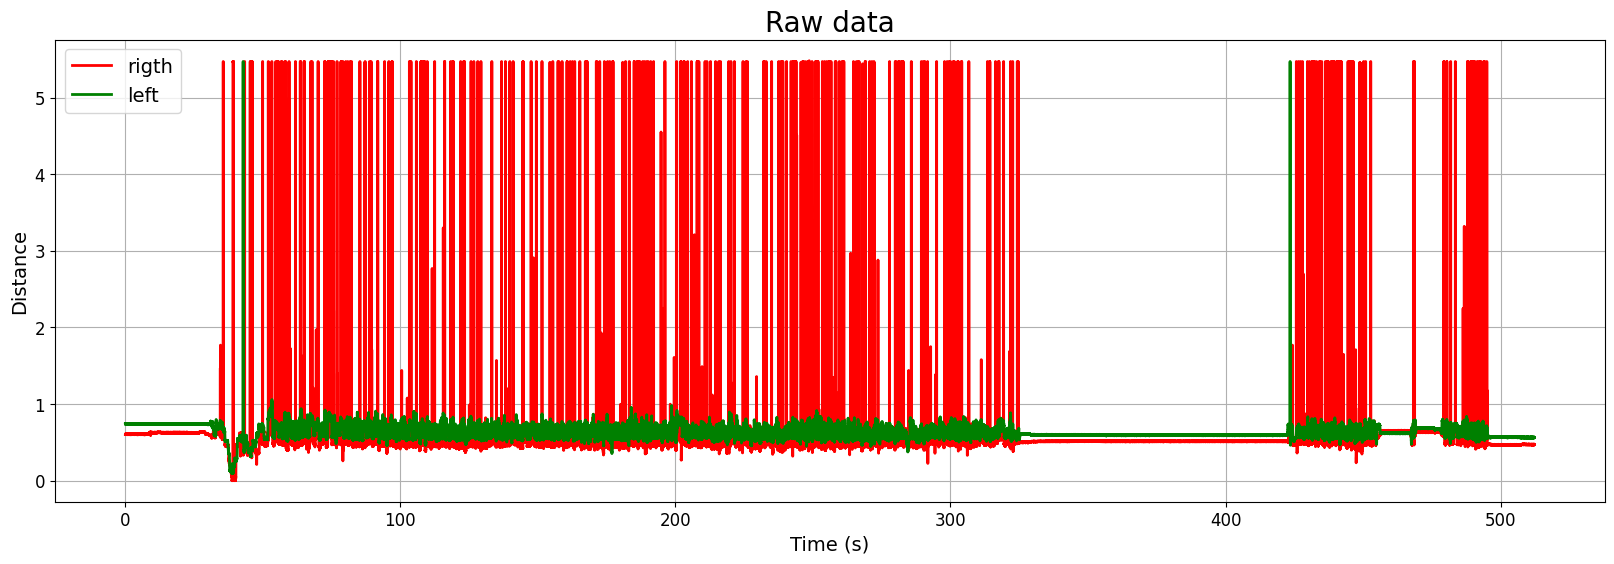

In [16]:
custom_multiplot(
    df['sec'], [df['right_disp'], df['left_disp']],
    title='Raw data',
    xlabel='Time (s)',
    ylabel='Distance',
    legend_labels=['rigth', 'left'],
    colors=['red', 'green'],
    title_size=20,
    label_font_size=14,
    tick_font_size=12,
    grid=True,
    figsize=(20, 6),
    xlog=False,
    ylog=False
)

A funtion is defined to remove the outliers using IQR method

<ipython-input-4-ccd7835e0e02>:38: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)

<ipython-input-4-ccd7835e0e02>:41: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)

<ipython-input-4-ccd7835e0e02>:51: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)

<ipython-input-4-ccd7835e0e02>:54: DeprecationWarning:

the `interpolation=` argument to percentile was renamed to `method=`, w

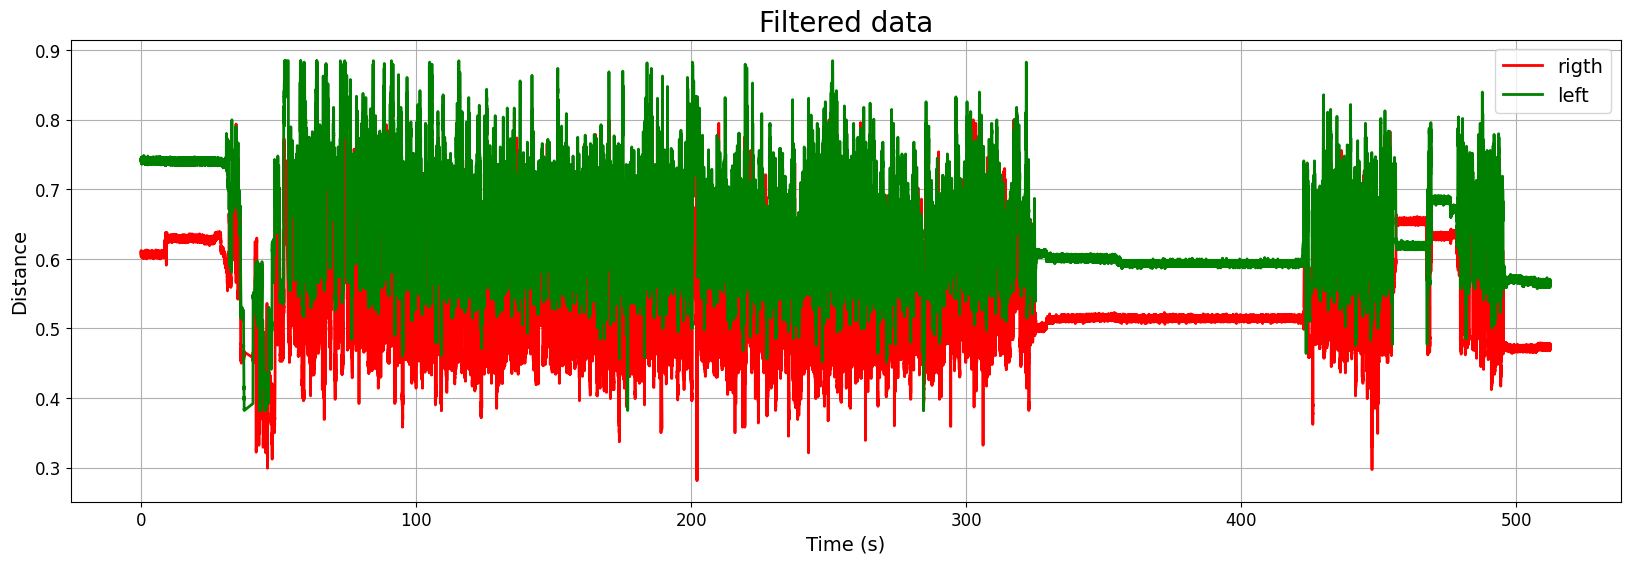

In [18]:
df = remove_outliers(df)
df.reset_index(inplace=True,drop=True)
custom_multiplot(
    df['sec'], [df['right_disp'], df['left_disp']],
    title='Filtered data',
    xlabel='Time (s)',
    ylabel='Distance',
    legend_labels=['rigth', 'left'],
    colors=['red', 'green'],
    title_size=20,
    label_font_size=14,
    tick_font_size=12,
    grid=True,
    figsize=(20, 6),
    xlog=False,
    ylog=False
)

A small section of the data (from time 100 s to 150 s) is selected to be used for training

In [10]:
df_train = df[(df['sec']<150) & (df['sec']>100)]

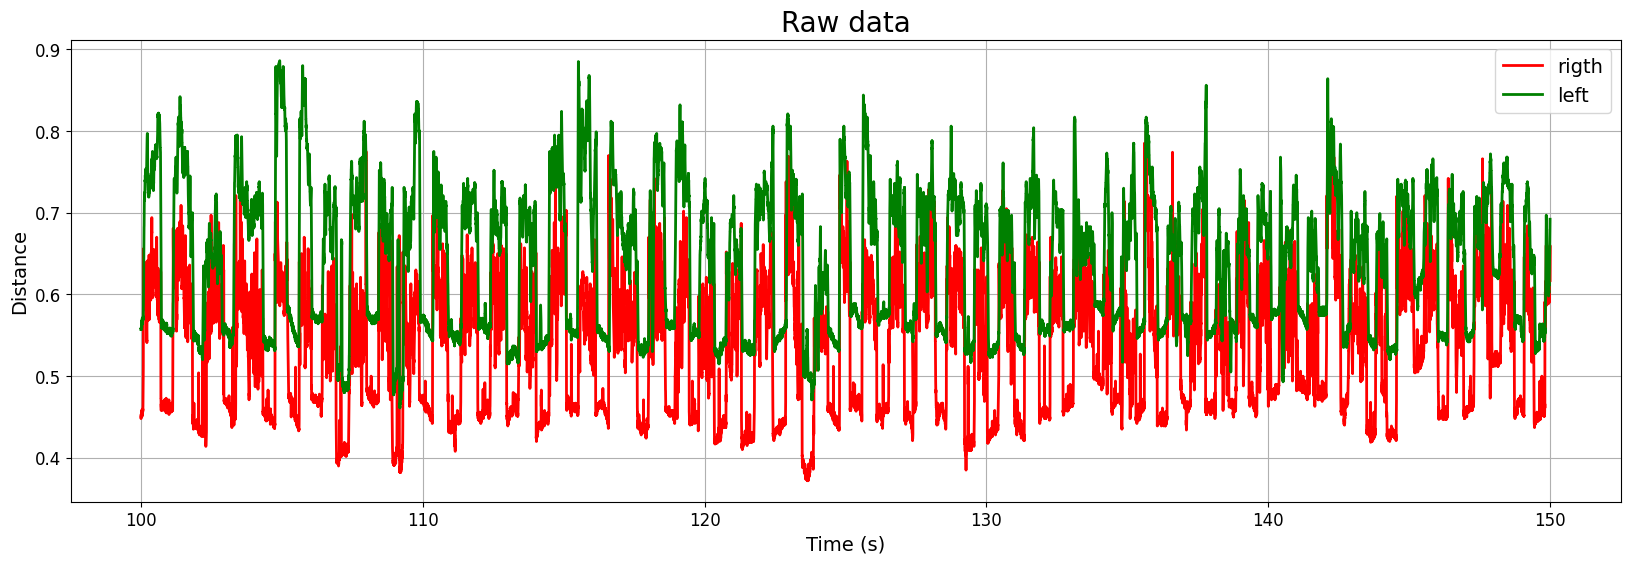

In [19]:
custom_multiplot(
    df_train['sec'], [df_train['right_disp'], df_train['left_disp']],
    title='Raw data',
    xlabel='Time (s)',
    ylabel='Distance',
    legend_labels=['rigth', 'left'],
    colors=['red', 'green'],
    title_size=20,
    label_font_size=14,
    tick_font_size=12,
    grid=True,
    figsize=(20, 6),
    xlog=False,
    ylog=False
)

Before starting the training, we should manually label the data points related to ties and ballast. In the training dataframe, there are 55 ties. For each tie, start and end times are recorded in a dataframe called tb. We eill use this information to label all the data points.

In [11]:
tb = pd.read_excel('/content/drive/MyDrive/CVeSS/TB/Huckelberry/Feb_8/tie_ballast.xlsx')

In [12]:
tb

,start,end
0,100.7126,101.1194
1,101.8343,102.2149
2,102.9581,103.3588
3,104.3255,104.7544
4,105.2398,105.6103
5,106.0574,106.4219
6,106.9415,107.3644
7,108.0149,108.4318
8,108.9312,109.0823
9,109.1769,109.2756


Labeling all the data points take place here. In this block, we go through each data point and we check to see if it belongs to tb dataframe. If it was we have Tie (1), else, ballast (0).

In [60]:
labels = np.zeros(len(df_train))

for i in range(len(df_train)):
  for j in range(len(tb['start'])):
    if df_train.iloc[i]['sec']<tb.iloc[j]['end']:
      if df_train.iloc[i]['sec']>tb.iloc[j]['start']:
        labels[i] = 1

In [61]:
df_train['labels'] = labels

<ipython-input-61-2c6fb1eeeeca>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
df_train

,sec,left_disp,right_disp,Yaw_disp,mag,x,y,z,temp,humid,sync,Tach,bat,date,UTC,labels
46608,100.0017,0.557,0.450,4.83,4.61,0.606,1.35,1.40,0.661,0.405,4.98,0.00369,1.29,2/8/2023,15:55:29,0.0
46609,100.0037,0.559,0.448,4.83,4.61,0.605,1.36,1.39,0.661,0.407,4.98,0.00369,1.30,2/8/2023,15:55:29,0.0
46610,100.0057,0.559,0.451,4.84,4.61,0.606,1.37,1.40,0.662,0.407,4.98,0.00369,1.29,2/8/2023,15:55:29,0.0
46611,100.0077,0.558,0.453,4.82,4.60,0.605,1.36,1.40,0.662,0.408,4.98,0.00369,1.30,2/8/2023,15:55:29,0.0
46612,100.0097,0.559,0.452,4.81,4.60,0.606,1.35,1.40,0.662,0.405,4.98,0.00369,1.29,2/8/2023,15:55:29,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71266,149.9904,0.665,0.646,3.86,4.60,0.584,1.35,1.39,0.661,0.399,4.98,0.00369,1.30,2/8/2023,15:56:18,0.0
71267,149.9924,0.673,0.652,3.88,4.60,0.585,1.36,1.40,0.660,0.399,4.98,0.00492,1.30,2/8/2023,15:56:18,0.0
71268,149.9944,0.680,0.660,3.88,4.61,0.585,1.36,1.40,0.661,0.401,4.98,0.00369,1.30,2/8/2023,15:56:18,0.0
71269,149.9965,0.684,0.644,3.87,4.60,0.584,1.36,1.40,0.659,0.402,4.98,0.00123,1.30,2/8/2023,15:56:18,0.0


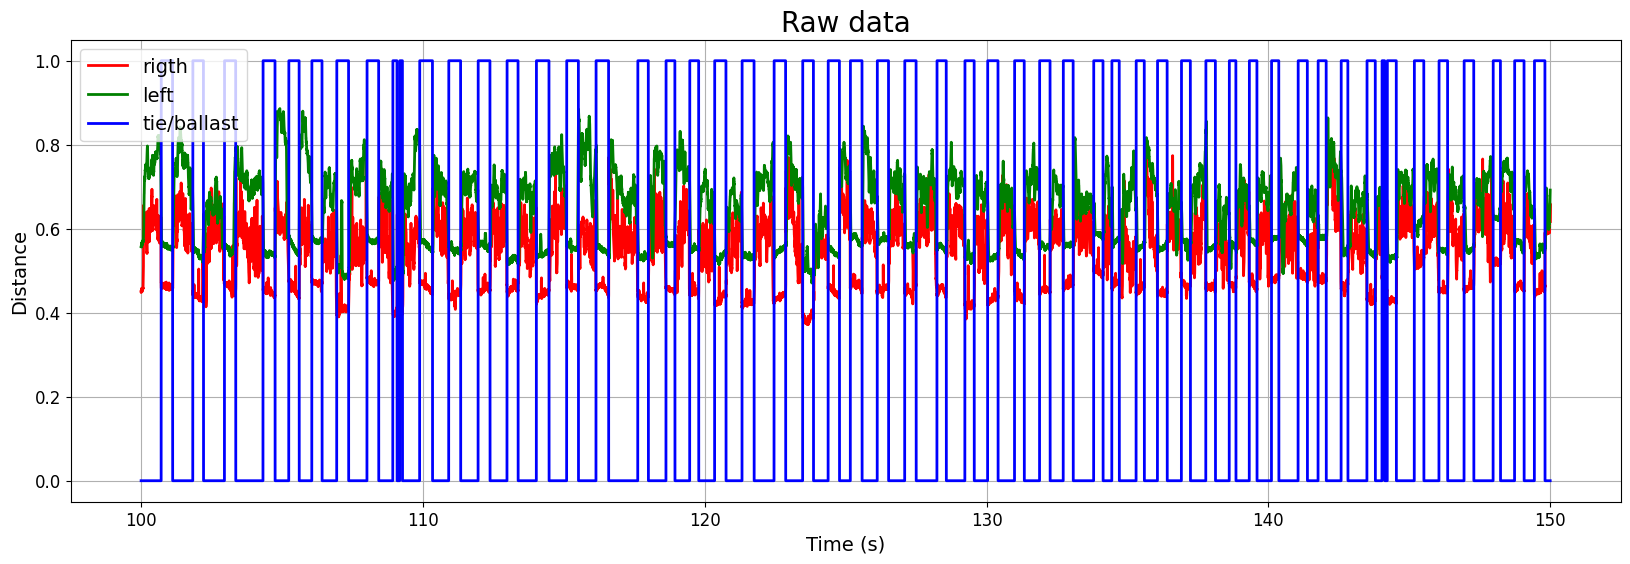

In [22]:
custom_multiplot(
    df_train['sec'], [df_train['right_disp'], df_train['left_disp'], df_train['labels']],
    title='Raw data',
    xlabel='Time (s)',
    ylabel='Distance',
    legend_labels=['rigth', 'left', 'tie/ballast'],
    colors=['red', 'green', 'blue'],
    title_size=20,
    label_font_size=14,
    tick_font_size=12,
    grid=True,
    figsize=(20, 6),
    xlog=False,
    ylog=False
)

In [66]:
df_train.to_csv('/content/drive/MyDrive/CVeSS/TB/Huckelberry/Feb_8/Labeled_DE9C0013.csv')

In [20]:
df_train = pd.read_csv('/content/drive/MyDrive/CVeSS/TB/Huckelberry/Feb_8/Labeled_DE9C0013.csv')

## Segmentizing the data

All the measured data will be stored in sequences of certain size. So the machine learning model will look at sequence of data not a single data point.

## Inputs

Three inputs are defined here to investigate which one yields better results.


*   Raw measurment
*   Difference of right and left
*   Standard deviation of difference





In [23]:
ws = 50

RDbatch = []
LDbatch = []
Diffbatch = []
STDDiff = []
target = []

#len(df_train) // ws * ws
for i in range(ws, len(df_train)):
  RDbatch.append(df_train.iloc[i-ws:i]['right_disp'])
  LDbatch.append(df_train.iloc[i-ws:i]['left_disp'])
  Diffbatch.append(df_train.iloc[i-ws:i]['left_disp'] - df_train.iloc[i-ws:i]['right_disp'])
  STDDiff.append(np.std(df_train.iloc[i-ws:i]['left_disp'] - df_train.iloc[i-ws:i]['right_disp']))
  if sum(df_train.iloc[i-ws:i]['labels']) >= ws/2:
    target.append(1)
  else:
    target.append(0)

In [24]:
STDofDiff = np.zeros([len(STDDiff), ws])

for i in range(ws, len(STDofDiff)):
  STDofDiff[i-ws][:] = np.array([STDDiff[i-ws:i]])

Data is scaled using StandardScaler

### Training the machine learning model on raw measurments using DecisionTress

In [25]:
X_train, X_test, y_train, y_test = train_test_split(np.array(LDbatch), target, test_size=0.25, random_state=0)

scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

decision_tree = DecisionTreeClassifier(random_state=456)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
precision,recall,fscore,support=score(y_test,y_pred,average='macro')

print("F Score for using one measurement : ", fscore)

F Score for using one measurement :  0.959993349532803


### Training the machine learning model on difference of right and left using DecisionTress

In [26]:
X_train, X_test, y_train, y_test = train_test_split(np.array(Diffbatch), target, test_size=0.25, random_state=0)

scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

decision_tree = DecisionTreeClassifier(random_state=456)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
precision,recall,fscore,support=score(y_test,y_pred,average='macro')

print("F Score for using difference of measurments : ", fscore)

F Score for using difference of measurments :  0.9173980177749999


### Training the machine learning model on standard deviation of difference of right and left using DecisionTress

In [27]:
X_train, X_test, y_train, y_test = train_test_split(np.array(STDofDiff), target, test_size=0.25, random_state=0)

scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

decision_tree = DecisionTreeClassifier(random_state=456)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
precision,recall,fscore,support=score(y_test,y_pred,average='macro')

print("F Score for using standard deviation of difference of measurmentst : ", fscore)

F Score for using standard deviation of difference of measurmentst :  0.9399797522284663


It can be seen that the raw measurments resulted in a better F-score. However, STD of difference more robust and is less sensitive in tie elevation. So we decided to move on with STD of difference as input.

## Optimum window size

In this section the optimum window size will be selected

In [28]:
t = []
fscoreVal = []
model = []

for w in range(50, 251, 50):
  ws = w
  RDbatch = []
  LDbatch = []
  Diffbatch = []
  STDDiff = []
  target = []

  #len(df_train) // ws * ws
  for i in range(ws, len(df_train)):
    RDbatch.append(df_train.iloc[i-ws:i]['right_disp'])
    LDbatch.append(df_train.iloc[i-ws:i]['left_disp'])
    Diffbatch.append(df_train.iloc[i-ws:i]['left_disp'] - df_train.iloc[i-ws:i]['right_disp'])
    STDDiff.append(np.std(df_train.iloc[i-ws:i]['left_disp'] - df_train.iloc[i-ws:i]['right_disp']))
    if sum(df_train.iloc[i-ws:i]['labels']) >= ws*0.75:
      target.append(1)
    else:
      target.append(0)

  STDofDiff = np.zeros([len(STDDiff), ws])
  for i in range(ws, len(STDofDiff)):
    STDofDiff[i-ws][:] = np.array([STDDiff[i-ws:i]])


  X_train, X_test, y_train, y_test = train_test_split(STDofDiff, target, test_size=0.25, random_state=0)
  scaler = StandardScaler()
  X_train=scaler.fit_transform(X_train)
  X_test=scaler.fit_transform(X_test)
  decision_tree = DecisionTreeClassifier(random_state=456)
  decision_tree.fit(X_train, y_train)
  y_pred = decision_tree.predict(X_test)
  precision,recall,fscore,support=score(y_test,y_pred,average='macro')

  model.append(decision_tree)
  t.append(ws)
  fscoreVal.append(fscore)

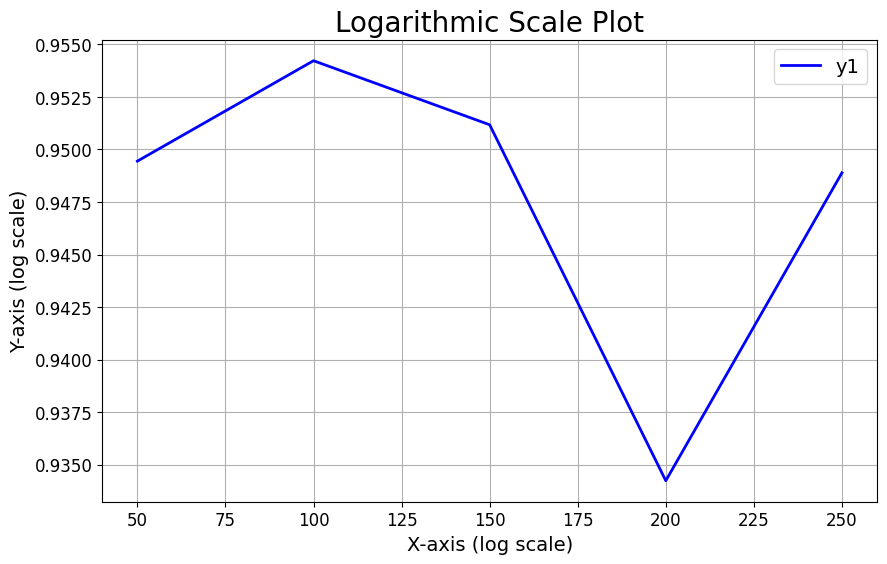

In [29]:
custom_multiplot(
    t, [fscoreVal],
    title='Logarithmic Scale Plot',
    xlabel='X-axis (log scale)',
    ylabel='Y-axis (log scale)',
    legend_labels=['y1', 'y2'],
    colors=['blue', 'red'],
    title_size=20,
    label_font_size=14,
    tick_font_size=12,
    grid=True,
    save_as='logarithmic_plot.png',
    figsize=(10, 6),
    xlog=False,
    ylog=False
)

# Validating the results

In  this section the trained model will be used to do the predictions on another section of the dataset.

In [30]:
df_test = df[(df['sec']<250) & (df['sec']>200)]
df_test.reset_index(inplace=True,drop=True)

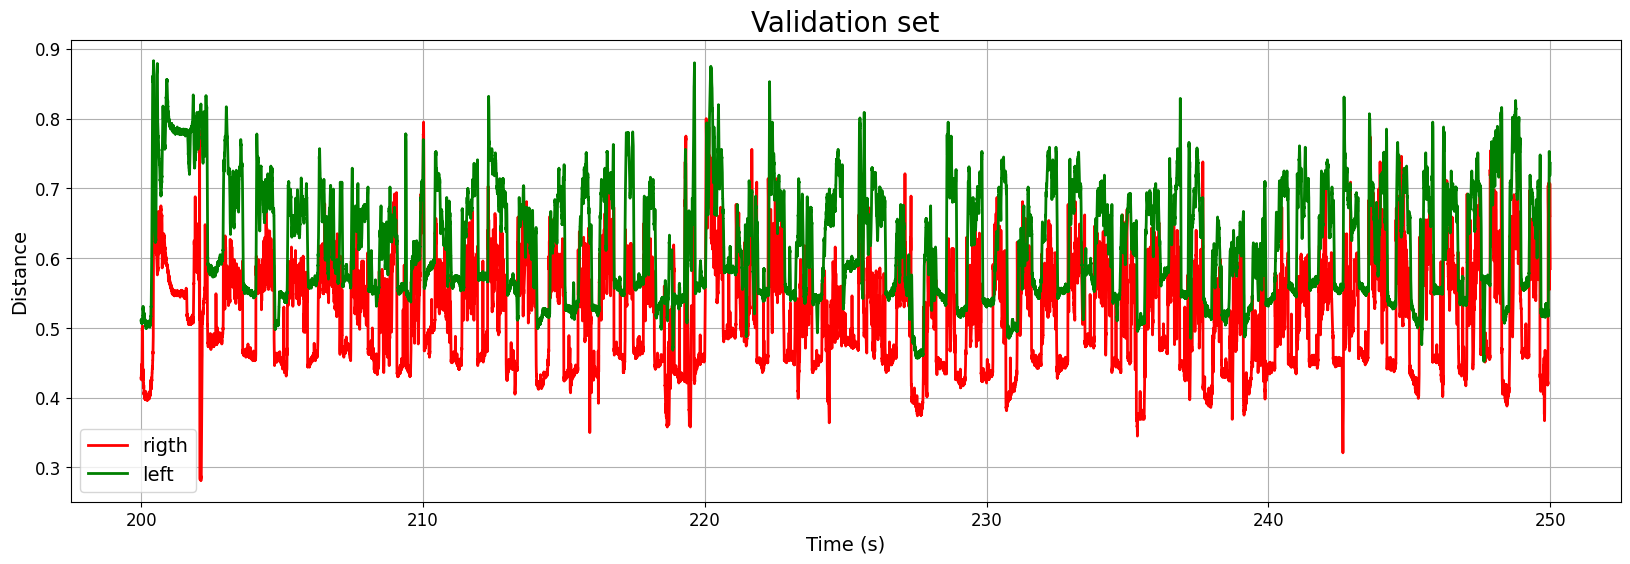

In [33]:
custom_multiplot(
    df_test['sec'], [df_test['right_disp'], df_test['left_disp']],
    title='Validation set',
    xlabel='Time (s)',
    ylabel='Distance',
    legend_labels=['rigth', 'left', 'tie/ballast'],
    colors=['red', 'green', 'blue'],
    title_size=20,
    label_font_size=14,
    tick_font_size=12,
    grid=True,
    figsize=(20, 6),
    xlog=False,
    ylog=False
)

In [32]:
ws = 100

STDDiff = []

for i in range(ws, len(df_test)):
  STDDiff.append(np.std(df_test.iloc[i-ws:i]['left_disp'] - df_test.iloc[i-ws:i]['right_disp']))

STDofDiff = np.zeros([len(STDDiff), ws])

for i in range(ws, len(STDofDiff)):
  STDofDiff[i-ws][:] = np.array([STDDiff[i-ws:i]])

X = STDofDiff
scaler = StandardScaler()
X = scaler.fit_transform(X)

y_pred = model[1].predict(X)

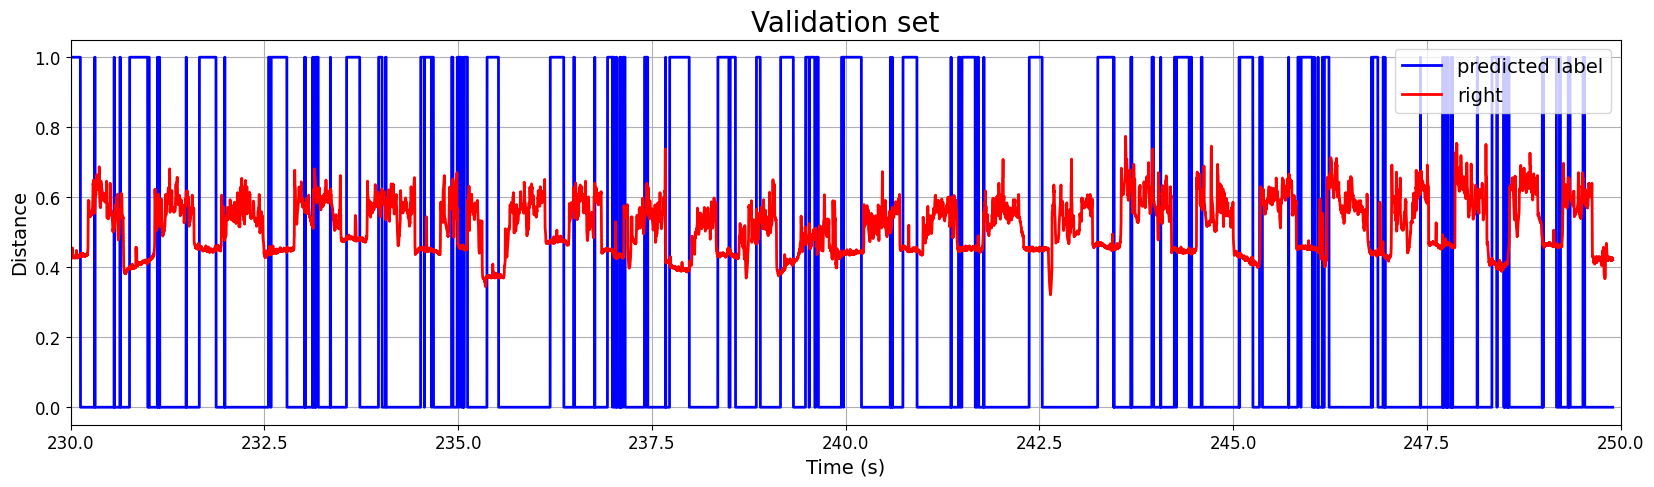

In [34]:
custom_multiplot(
    df_test.iloc[ws//2:-ws//2]['sec'], [y_pred, df_test.iloc[ws//2:-ws//2]['right_disp']],
    title='Validation set',
    xlabel='Time (s)',
    ylabel='Distance',
    legend_labels=['predicted label', 'right'],
    colors=['blue', 'red'],
    title_size=20,
    label_font_size=14,
    tick_font_size=12,
    grid=True,
    figsize=(20, 5),
    xlim=(230,250),
    xlog=False,
    ylog=False
)